확실한 spammer에 대한 정보를 가지기 위해서 (training에 사용할 데이터)

조건1 : reviewer Burstiness (RB) - focused on product (한 제품에 일정 날에 리뷰를 많이남긴 리뷰어)

조건2 : reviewer who has a lot of reviews (minimum리뷰수를 적절히 바꿔가면서 리뷰가 많은 리뷰어 찾기)

조건3 : 상호명(아뜨랑스, 고고싱, 스타일난다(난다))를 직접적으로 언급한 리뷰

조건4 : 평균 rScore가 5에 가까운 리뷰어

조건5 : 한 제품에 여러번 리뷰를 남긴 리뷰어

5개 모두 적용되는 리뷰어

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from konlpy.utils import pprint 

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:3: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:3: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: n

In [2]:
#gogosing
common_front = '../../dataset/go_0715/gogosing_' 
common_back = '.json'

def get_file(file_num):   
    file_path = common_front + str(file_num) + common_back
    json_data = open(file_path).read()
    data = json.loads(json_data)
    df_data = pd.DataFrame(data)
    return df_data

# 74번 파일이 에러가 나서 제외함
def concat_file(file_num):
    start_file = pd.DataFrame(get_file(1))
    for i in range(2,file_num+1):
        if( i == 74):
            continue
        df_tmp = pd.DataFrame(get_file(i))
        start_file = pd.concat([start_file, df_tmp])
    start_file = start_file.reset_index(drop=True)
    return start_file

go_data = concat_file(156)

In [3]:
print("total number of reviews in gogosing : " + str(go_data.shape[0]) )

total number of reviews in gogosing : 772829


# 네이버 페이 구매자 rScore 수정하기

In [4]:
naverpay = (go_data.loc[go_data['cId'] == u'네이버 페이 구매자'])
naverpay['rScore'].value_counts()

5.0    52539
Name: rScore, dtype: int64

In [5]:
for i in range(go_data.shape[0]):
    if(go_data.loc[i, 'cId'] == u'네이버 페이 구매자'):
        if(go_data.loc[i, 'desc'][0] == u'만'):
            go_data.loc[i, 'rScore'] = 5.0
        elif(naverpay.loc[i, 'desc'][0] == u'불'):
            go_data.loc[i, 'rScore'] = 1.0
        elif(naverpay.loc[i, 'desc'][0] == u'보'):
            go_data.loc[i, 'rScore'] = 3.0
    else:
        continue

# condition 1 : reviewer Burstiness (RB) - focused on product

(한 제품에 일정 날에 리뷰를 많이남긴 리뷰어)

In [6]:
def burst_in_product(min_count, dataframe):
    condition1 = []
    product_burst = pd.DataFrame({'count' : dataframe.groupby( [ "pID", "rDate", "cId"] ).size()}).reset_index()
    suspicious_reviewers = (product_burst[product_burst['count'] >= min_count])['cId']
    for reviewer in suspicious_reviewers:
        condition1.append(reviewer)
    return remove_duplicate_from_list(condition1)
    

In [7]:
def remove_duplicate_from_list(input_list):
    tmp_set = set(input_list)
    result = list(tmp_set)
    return result

# condition 2 : reviewer who has a lot of reviews

(minimum리뷰수를 적절히 바꿔가면서 리뷰가 많은 리뷰어 찾기)

In [8]:
def find_reviewer_who_has_many_reviews(min_review, dataframe):
    condition2 = []
    reviewer_and_reviews = dataframe['cId'].value_counts()
    suspicious_reviewers = reviewer_and_reviews[reviewer_and_reviews >= min_review].index
    for reviewer in suspicious_reviewers:
        condition2.append(reviewer)
    return condition2


# condition 3 : 상호명(아뜨랑스, 고고싱, 스타일난다(난다))를 직접적으로 언급한 리뷰어

In [9]:
def reviewer_who_directly_write_sitename(min_count, dataframe):
    condition3 = [] 
    reviewer_who_write_sitename = dataframe[dataframe['desc'].str.contains(u"고고싱")]
    reviewer_and_reviews = reviewer_who_write_sitename['cId'].value_counts()
    suspicious_reviewers = reviewer_and_reviews[reviewer_and_reviews >= min_count].index
    for reviewer in suspicious_reviewers:
        condition3.append(reviewer)
        
    return condition3

# condition4 : 평균 rScore가 5에 가까운 리뷰어

In [10]:
def reviewer_who_has_high_rscore(min_rscore, dataframe):
    condition4 = [] 
    mean_rscore = dataframe.groupby(dataframe.cId).mean()['rScore']
    suspicious_reviewers = mean_rscore[mean_rscore >= min_rscore].index
    for reviewer in suspicious_reviewers:
        condition4.append(reviewer)
        
    return condition4

In [11]:
def intersect(lst1, lst2):
    return list(set(lst1) & set(lst2))

#spam_reviewers = (intersect(intersect(intersect(condition3, condition4), condition2), condition1))
#pprint(spam_reviewers)

# condition 5 : reviewer who has many reviews in A product over all time

In [12]:
def reviewer_who_has_many_reviews_in_a_product(min_count, dataframe):
    condition5 = []
    product_burst = pd.DataFrame({'count' : dataframe.groupby( [ "pID", "cId"] ).size()}).reset_index()
    suspicious_reviewers = (product_burst[product_burst['count'] >= min_count])['cId']
    for reviewer in suspicious_reviewers:
        condition5.append(reviewer)
    
    return remove_duplicate_from_list(condition5)

#reviewer_who_has_many_reviews_in_a_product(7)

# condition 6 : reviewer who has many reviews in A day

In [13]:
def reviewer_who_has_many_reviews_in_a_day(min_count, dataframe):
    condition6 = []
    date_burst = pd.DataFrame({'count' : dataframe.groupby( [ "rDate", "cId"] ).size()}).reset_index()
    suspicious_reviewers = (date_burst[date_burst['count'] >= min_count])['cId']
    for reviewer in suspicious_reviewers:
        condition6.append(reviewer)
    
    return remove_duplicate_from_list(condition6)

# reviewer_who_satisfy_some_condition - intersect ver.

In [31]:
intersect_public_total = []
intersect_public_rscore_5 = []
intersect_public_rscore_4 = []
intersect_public_rscore_3 = []
intersect_public_rscore_2 = []
intersect_public_rscore_1 = []

In [32]:
'''
cond1 : 한 제품 & 특정 날짜에 cond1개 초과로 남긴 리뷰어
cond2 : cond2개 초과의 리뷰를 가진 리뷰어
cond3 : 상호명 언급을 cond3번 초과한 리뷰어
cond4 : 평점 cond4초과 리뷰어
cond5 : 한제품에 cond5개 초과로 리뷰남긴 리뷰어 추가하기
'''
def reviewer_who_satisfy_some_condition(dataframe, cond1_bool, cond2_bool, cond3_bool, cond4_bool, cond5_bool, cond6_bool,
                                        cond1, cond2, cond3, cond4, cond5, cond6, max_rscore):
    
    unique_cid = dataframe.cId.unique()
    #condition1
    if(cond1_bool == 1):
        reviewer1 = burst_in_product(cond1, dataframe)
    else:
        reviewer1 = unique_cid
    
    #condition2
    if(cond2_bool == 1):
        reviewer2 = find_reviewer_who_has_many_reviews(cond2, dataframe)
    else:
        reviewer2 = unique_cid
        
    #condition3
    if(cond3_bool == 1):
        reviewer3 = reviewer_who_directly_write_sitename(cond3, dataframe)
    else:
        reviewer3 = unique_cid
    
    #condition4
    if(cond4_bool == 1):
        reviewer4 = reviewer_who_has_high_rscore(cond4, dataframe)
    else:
        reviewer4 = unique_cid
        
    #condition5
    if(cond5_bool == 1):
        reviewer5 = reviewer_who_has_many_reviews_in_a_product(cond5, dataframe)
    else:
        reviewer5 = unique_cid
        
     #condition6
    if(cond6_bool == 1):
        reviewer6 = reviewer_who_has_many_reviews_in_a_day(cond6, dataframe)
    else:
        reviewer6 = unique_cid
        
    spam_reviewers = intersect(intersect(intersect(intersect(intersect(reviewer1, reviewer2), reviewer3), reviewer4), reviewer5), reviewer6)
    
    #네이버 페이 구매자는 제외
    if(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790' in spam_reviewers):
        spam_reviewers.remove(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790')
    
    except_spam_in_gogosing = dataframe[~dataframe.cId.isin(spam_reviewers)]
    print("the number of spam_reviewers : " + str(len(spam_reviewers)))
    print("the number of non spam reviewers : " + str(len(except_spam_in_gogosing.cId.unique())))
    
    #제외될 리뷰중 3.0 이하의 리뷰는 제거하지 않음
    low_rscore_in_spam_reviewers = (dataframe[dataframe.cId.isin(spam_reviewers)]).loc[dataframe['rScore']<= max_rscore]
    except_spam_in_gogosing = pd.concat([except_spam_in_gogosing, low_rscore_in_spam_reviewers])
    
    print("<rScore distribution>")
    print("cond1 =" + str(cond1) + ", cond2 =" + str(cond2) + ", cond3 =" + str(cond3) + ", cond4 =" + str(cond4) + ", cond5 =" + str(cond5) + ", cond6 = " + str(cond6))
    rscore = except_spam_in_gogosing['rScore'].value_counts()
    intersect_public_total.append(except_spam_in_gogosing.shape[0])
    intersect_public_rscore_5.append(rscore[5.0])
    intersect_public_rscore_4.append(rscore[4.0])
    intersect_public_rscore_3.append(rscore[3.0])
    intersect_public_rscore_2.append(rscore[2.0])
    intersect_public_rscore_1.append(rscore[1.0])
    
    
    #print("except spam in gogosing : " )
    #print(except_spam_in_gogosing)

    
    if(not(5.0 in rscore.index)):
        add_row = pd.Series([1], index=[5.0])
        rscore = rscore.add(add_row)
    if(not(4.0 in rscore.index)):
        add_row = pd.Series([1], index=[4.0])
        rscore = rscore.add(add_row)
    if(not(3.0 in rscore.index)):
        add_row = pd.Series([1], index=[3.0])
        rscore = rscore.add(add_row)
    if(not(2.0 in rscore.index)):
        add_row = pd.Series([1], index=[2.0])
        rscore = rscore.add(add_row)
    if(not(1.0 in rscore.index)):
        add_row = pd.Series([1], index=[1.0])
        rscore = rscore.add(add_row)
        
    print("\n")
    print("rscore : ")
    print(rscore)        
    
    print ("ratio btw 5.0 and 4.0 : " + str(float(rscore[5.0])/float(rscore[4.0])))
    print ("ratio btw 5.0 and 3.0 : " + str(float(rscore[5.0])/float(rscore[3.0])))
    print ("ratio btw 5.0 and 2.0 : " + str(float(rscore[5.0])/float(rscore[2.0])))
    print ("ratio btw 5.0 and 1.0 : " + str(float(rscore[5.0])/float(rscore[1.0])))
    
    print ("the number of 5.0 reviews : " + str(rscore[5.0]))
    print ("the number of 4.0 reviews : " + str(rscore[4.0]))
    print ("the number of 3.0 reviews : " + str(rscore[3.0]))
    print ("the number of 2.0 reviews : " + str(rscore[2.0]))
    print ("the number of 1.0 reviews : " + str(rscore[1.0]))
       
    print(spam_reviewers)
        
    score = ('5.0', '4.0', '3.0', '2.0', '1.0')
    number_of_reviews = [rscore[5.0],
                     rscore[4.0],
                     rscore[3.0],
                     rscore[2.0],
                     rscore[1.0]]

    plt.bar(score, number_of_reviews, color=['red'],
        width=0.3, alpha=0.5)
    plt.xticks(score, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('# of review', fontsize=15)
    plt.rcParams["figure.figsize"] = (6,4)
    plt.xlabel('rScore', fontsize=15)
    ax = plt.gca()
    ax.set_ylim([0.0, except_spam_in_gogosing.shape[0]+500])
    plt.show()
    print("\n\n")
    return spam_reviewers


# reviewer_who_satisfy_some_condition - union ver.

In [14]:
union_public_total = []
union_public_rscore_5 = []
union_public_rscore_4 = []
union_public_rscore_3 = []
union_public_rscore_2 = []
union_public_rscore_1 = []

In [20]:
def reviewer_who_satisfy_some_condition_union(dataframe, cond1_bool, cond2_bool, cond3_bool, cond4_bool, cond5_bool, cond6_bool,
                                        cond1, cond2, cond3, cond4, cond5, cond6, max_rscore):
    
     #condition1
    if(cond1_bool == 1):
        reviewer1 = burst_in_product(cond1, dataframe)
    else:
        reviewer1 = []
    
    #condition2
    if(cond2_bool == 1):
        reviewer2 = find_reviewer_who_has_many_reviews(cond2, dataframe)
    else:
        reviewer2 = []
        
    #condition3
    if(cond3_bool == 1):
        reviewer3 = reviewer_who_directly_write_sitename(cond3, dataframe)
    else:
        reviewer3 = []
    
    #condition4
    if(cond4_bool == 1):
        reviewer4 = reviewer_who_has_high_rscore(cond4, dataframe)
    else:
        reviewer4 = []
        
    #condition5
    if(cond5_bool == 1):
        reviewer5 = reviewer_who_has_many_reviews_in_a_product(cond5, dataframe)
    else:
        reviewer5 = []  

    #condition6
    if(cond6_bool == 1):
        reviewer6 = reviewer_who_has_many_reviews_in_a_day(cond6, dataframe)
    else:
        reviewer6 = []
        
    spam_reviewers = remove_duplicate_from_list(reviewer1 + reviewer2 + reviewer3 + reviewer4 + reviewer5 + reviewer6)
    
    
    #네이버 페이 구매자는 스패머에서 일단 제외
    if(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790' in spam_reviewers):
        spam_reviewers.remove(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790')
    
    except_spam_in_gogosing = dataframe[~dataframe.cId.isin(spam_reviewers)]
    print("total number of expected non-spam reviewers : " + str(len(except_spam_in_gogosing.cId.unique()))) 
    
    #제외될 리뷰중 3.0 이하의 리뷰는 제거하지 않음
    low_rscore_in_spam_reviewers = (dataframe[dataframe.cId.isin(spam_reviewers)]).loc[dataframe['rScore']<= max_rscore]
    except_spam_in_gogosing = pd.concat([except_spam_in_gogosing, low_rscore_in_spam_reviewers])
    
    print("total number of suspicious spam reviewers : " + str(len(spam_reviewers)))
      
    print("<rScore distribution>")
    print("cond1 =" + str(cond1) + ", cond2 =" + str(cond2) + ", cond3 =" + str(cond3) + ", cond4 =" + str(cond4) + ", cond5 =" + str(cond5) + ", cond6 =" + str(cond6)) 
    
    rscore = except_spam_in_gogosing['rScore'].value_counts()

    if(not(5.0 in rscore.index)):
        add_row = pd.Series([1], index=[5.0])
        rscore = rscore.add(add_row)
    if(not(4.0 in rscore.index)):
        add_row = pd.Series([1], index=[4.0])
        rscore = rscore.add(add_row)
    if(not(3.0 in rscore.index)):
        add_row = pd.Series([1], index=[3.0])
        rscore = rscore.add(add_row)
    if(not(2.0 in rscore.index)):
        add_row = pd.Series([1], index=[2.0])
        rscore = rscore.add(add_row)
    if(not(1.0 in rscore.index)):
        add_row = pd.Series([1], index=[1.0])
        rscore = rscore.add(add_row)  
        
    union_public_total.append(except_spam_in_gogosing.shape[0])
    union_public_rscore_5.append(rscore[5.0])
    union_public_rscore_4.append(rscore[4.0])
    union_public_rscore_3.append(rscore[3.0])
    union_public_rscore_2.append(rscore[2.0])
    union_public_rscore_1.append(rscore[1.0])

    non_spam_reviewers = except_spam_in_gogosing.cId.unique()
    non_spam_reviewers = non_spam_reviewers.tolist()
    
    if(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790' in non_spam_reviewers):
        non_spam_reviewers.remove(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790')
   
    print ("ratio btw 5.0 and 4.0 : " + str(float(rscore[5.0])/float(rscore[4.0])))
    print ("ratio btw 5.0 and 3.0 : " + str(float(rscore[5.0])/float(rscore[3.0])))
    print ("ratio btw 5.0 and 2.0 : " + str(float(rscore[5.0])/float(rscore[2.0])))
    print ("ratio btw 5.0 and 1.0 : " + str(float(rscore[5.0])/float(rscore[1.0])))
    

    print ("the number of 5.0 reviews : " + str(rscore[5.0]))
    print ("the number of 4.0 reviews : " + str(rscore[4.0]))
    print ("the number of 3.0 reviews : " + str(rscore[3.0]))
    print ("the number of 2.0 reviews : " + str(rscore[2.0]))
    print ("the number of 1.0 reviews : " + str(rscore[1.0]))
    
                    
    score = ('5.0', '4.0', '3.0', '2.0', '1.0')
    number_of_reviews = [rscore[5.0],
                     rscore[4.0],
                     rscore[3.0],
                     rscore[2.0],
                     rscore[1.0]]

    plt.bar(score, number_of_reviews, color=['red'],
        width=0.3, alpha=0.5)
    plt.xticks(score, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('# of review', fontsize=15)
    plt.rcParams["figure.figsize"] = (6,4)
    plt.xlabel('rScore', fontsize=15)
    ax = plt.gca()
    ax.set_ylim([0.0, except_spam_in_gogosing.shape[0]+1000])
    plt.show()
    print("\n\n")
    return non_spam_reviewers

# union result

total number of expected non-spam reviewers : 33324
total number of suspicious spam reviewers : 105326
<rScore distribution>
cond1 =30, cond2 =100, cond3 =15, cond4 =5.0, cond5 =10, cond6 =30
ratio btw 5.0 and 4.0 : 5.62891470471
ratio btw 5.0 and 3.0 : 9.50247940047
ratio btw 5.0 and 2.0 : 58.308396248
ratio btw 5.0 and 1.0 : 68.4387755102
the number of 5.0 reviews : 254866
the number of 4.0 reviews : 45278
the number of 3.0 reviews : 26821
the number of 2.0 reviews : 4371
the number of 1.0 reviews : 3724


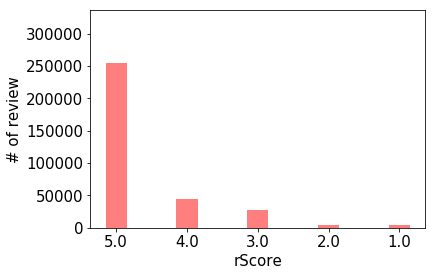

In [117]:
union_result = reviewer_who_satisfy_some_condition_union(go_data, 1, 1, 1, 1, 1, 1, 30, 100, 15, 5.0, 10, 30, -1)

In [118]:
union_result_df = pd.DataFrame(union_result)
writer = pd.ExcelWriter('gogosing_feature1.xlsx')
union_result_df.to_excel(writer,'Sheet1')
writer.save()

In [55]:
num_cId = go_data['cId'].value_counts()
num_cId = pd.DataFrame(num_cId)
print(num_cId)

                      cId
네이버 페이 구매자          52539
rkdldk5**             475
yeji04**              449
elqxhs**              339
dnv**                 314
rladmswl9708**        308
wlgus5**              305
pp**                  301
wertyuio9**           292
sumin12**             278
dldmsql10**           276
kma05**               271
dream3**              245
rudgml72**            244
soa12**               237
kimhani3**            210
45216058**            209
sjj44**               197
rlaqhfk5**            193
tladnjs2**            191
tpwls12**             190
jy03**                189
egll**                188
jeje05**              187
bha11**               186
hooming**             186
tofha40**             186
ds357**               185
miliastla**           183
phr9101**             183
...                   ...
유민지                     1
461301292**             1
gook**                  1
byeolttar**             1
1698601763758607**      1
tjddlaks1**             1
eofhdrk**   

In [ ]:
tmp = num_cId
for i in range(len(num_cId)):
    for j in range(len(union_result)):
        if(num_cId.index[i]==union_result[j]):
            tmp = tmp.drop(num_cId.index[i])
            break;

In [ ]:
len(tmp)

# intersection result 

the number of spam_reviewers : 102
the number of non spam reviewers : 138548
<rScore distribution>
cond1 =3, cond2 =30, cond3 =5, cond4 =4.5, cond5 =3, cond6 = 5


rscore : 
5.0    682372
4.0     46558
3.0     27342
2.0      4526
1.0      3809
Name: rScore, dtype: int64
ratio btw 5.0 and 4.0 : 14.6563855836
ratio btw 5.0 and 3.0 : 24.9569160998
ratio btw 5.0 and 2.0 : 150.767123288
ratio btw 5.0 and 1.0 : 179.147282751
the number of 5.0 reviews : 682372
the number of 4.0 reviews : 46558
the number of 3.0 reviews : 27342
the number of 2.0 reviews : 4526
the number of 1.0 reviews : 3809
[u'yeji09**', u'rladmswl9708**', u'wldwldg**', u'zlzlzlgk**', u'm0928hy**', u'gloryn**', u'sestt**', u'hj07**', u'liebeont**', u'np09**', u'chae64**', u'jilleo03**', u'dkdudss**', u'dbtmfg**', u'kimminji**', u'dpwl09**', u'ch**', u'acua**', u'tyvkcla**', u'wertyuio9**', u'gzo08**', u'minalee08**', u'sindyo**', u'rhdms10**', u'nabi**', u'swhs**', u'ljhyun12**', u'tnqls48**', u'48734400**', u'jongdea**', u'

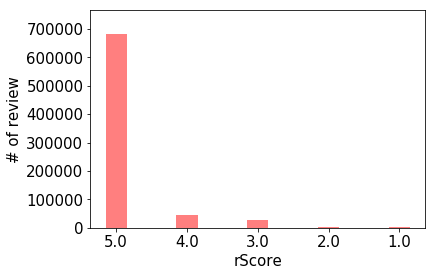

In [90]:
intersection_result = reviewer_who_satisfy_some_condition(go_data, 1, 1, 1, 1, 1, 1, 3, 30, 5, 4.5, 3, 5, -1)

In [91]:
union_result_df = pd.DataFrame(intersection_result)
writer = pd.ExcelWriter('gogosing_feature_intersection.xlsx')
union_result_df.to_excel(writer,'Sheet1')
writer.save()

# Feature1

In [70]:
cond1_cid = burst_in_product(10, go_data)
cond1_cid_df = pd.DataFrame(cond1_cid)
cond1_cid_df

,0
0,네이버 페이 구매자
1,cka**
2,dekuu12**


In [78]:
writer = pd.ExcelWriter('gogosing_feature_cond1.xlsx')
cond1_cid_df.to_excel(writer,'Sheet1')
writer.save()

# Feature2

In [71]:
cond2_cid = find_reviewer_who_has_many_reviews(100, go_data)
cond2_cid_df = pd.DataFrame(cond2_cid)
cond2_cid_df

,0
0,네이버 페이 구매자
1,rkdldk5**
2,yeji04**
3,elqxhs**
4,dnv**
5,rladmswl9708**
6,wlgus5**
7,pp**
8,wertyuio9**
9,sumin12**


In [79]:
writer = pd.ExcelWriter('gogosing_feature_cond2.xlsx')
cond2_cid_df.to_excel(writer,'Sheet1')
writer.save()

# Feature3

In [72]:
cond3_cid = reviewer_who_directly_write_sitename(15, go_data)
cond3_cid_df = pd.DataFrame(cond3_cid)
cond3_cid_df

,0
0,네이버 페이 구매자
1,rkdldk5**
2,seoa40**
3,sumin12**
4,dekuu12**
5,duwls**
6,sksmsor**
7,jjh86**
8,yeagar**
9,yeji04**


In [80]:
writer = pd.ExcelWriter('gogosing_feature_cond3.xlsx')
cond3_cid_df.to_excel(writer,'Sheet1')
writer.save()

# Feature4

In [87]:
cond4_cid = reviewer_who_has_high_rscore(4.98, go_data)
cond4_cid_df = pd.DataFrame(cond4_cid)
cond4_cid_df

,0
0,*.*
1,100002938**
2,100007624**
3,100066407**
4,100077919**
5,100104336**
6,10011232**
7,100113192**
8,100141693**
9,1001595463332264**


In [81]:
writer = pd.ExcelWriter('gogosing_feature_cond4.xlsx')
cond4_cid_df.to_excel(writer,'Sheet1')
writer.save()

# Feature5

In [75]:
cond5_cid = reviewer_who_has_many_reviews_in_a_product(10, go_data)
cond5_cid_df = pd.DataFrame(cond5_cid)
cond5_cid_df

,0
0,네이버 페이 구매자
1,kes08**
2,8998887**
3,peh**
4,y333**
5,cka**
6,dekuu12**
7,suyeon46**


In [82]:
writer = pd.ExcelWriter('gogosing_feature_cond5.xlsx')
cond5_cid_df.to_excel(writer,'Sheet1')
writer.save()

# Feature6

In [76]:
cond6_cid = reviewer_who_has_many_reviews_in_a_day(15, go_data)
cond6_cid_df = pd.DataFrame(cond6_cid)
cond6_cid_df

,0
0,o3oz**
1,dnjswn**
2,wijkuv90**
3,leeean**
4,gldidus**
5,dri30**
6,43280405**
7,kahlua**
8,sasadng10**
9,he0305**


In [83]:
writer = pd.ExcelWriter('gogosing_feature_cond6.xlsx')
cond6_cid_df.to_excel(writer,'Sheet1')
writer.save()

# Attrangs

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from konlpy.tag import Twitter
from konlpy.utils import pprint
twitter = Twitter()
from collections import Counter

pd.set_option('max_colwidth', 500)

common_front = '../../dataset/art_0715/artlance_' 
common_back = '.json'

def get_file(file_num):   
    file_path = common_front + str(file_num) + common_back
    json_data = open(file_path).read()
    data = json.loads(json_data)
    df_data = pd.DataFrame(data)
    return df_data

def concat_file(file_num):
    start_file = pd.DataFrame(get_file(1))
    for i in range(2,file_num+1):
        df_tmp = pd.DataFrame(get_file(i))
        start_file = pd.concat([start_file, df_tmp])
    start_file = start_file.reset_index(drop=True)
    return start_file

In [95]:
att_data = concat_file(56)

In [96]:
len(att_data)

279708

In [97]:
att_data

,_id,bodySize,cId,desc,height,helpful,pColor,pID,pSize,pTitle,pURL,rDate,rImages,rNo,rScore,weight
0,artlance_298371,44반,carul12**,치마바지 청으로 처음사봤는데 캐주얼하고 예뻐요! 여름에 치마는 안에보일까 걱정 바지는 식상해서 사봤어요 ㅎㅎ,156.0,"[0, 0]",DarkBlue(model),40401,S,ps1360 걸리시한 랩스타일의 데일리 데님 숏 팬츠 pants,http://attrangs.com/shop/view.php?index_no=40401,2018. 07. 15,"[assets3.cre.ma/p/attrangs-co-kr/reviews/00/00/29/83/71/image1/thumbnail_0d25d8179ef38969.jpg, assets3.cre.ma/p/attrangs-co-kr/reviews/00/00/29/83/71/image1/thumbnail_0d25d8179ef38969.jpg]",298371,5.0,46~49kg
1,artlance_298370,NaN,cuteseon**,리뷰에사이즈관련해서넘다양한얘기들이있어서엄청고민했어여~~근데..정사이즈사시면될듯여..ㅎ제가완전마르지두않았는데S가넘딱!붙거나하진않아여~~색두시원해보이고..키가작은편이라기장추가안해두많이짧지않구적당하구여~다른색두사구싶네여..다만..제가결제하자마자더가격이내려갔더라는..ㅠㅠ그래두저렴하게예쁜원피스샀네요^^,156.0,"[0, 0]",SkyBlue,40152,S,op4983 썸머 데일리룩을 책임져줄 린넨소재의 5컬러 슬리브리스 원피스 dress,http://attrangs.com/shop/view.php?index_no=40152,2018. 07. 15,NaN,298370,5.0,NaN
2,artlance_298369,44반,carul12**,두줄초커가 시선을끌고 옷이 밋밋해지지않도록해주네요 ㅎㅎ 가슴부분이 옷이 자꾸 내려가는거같아서 그건좀 아쉬워요,156.0,"[0, 0]",Ivory(model),40380,Free,ts1141 레이스 2줄 초커 디테일의 U네크라인 티셔츠 tee,http://attrangs.com/shop/view.php?index_no=40380,2018. 07. 15,"[assets3.cre.ma/p/attrangs-co-kr/reviews/00/00/29/83/69/image1/thumbnail_2ee7837d8f0e2722.jpg, assets3.cre.ma/p/attrangs-co-kr/reviews/00/00/29/83/69/image1/thumbnail_2ee7837d8f0e2722.jpg]",298369,5.0,46~49kg
3,artlance_298368,44반,carul12**,하얀나시가 안에속옷을 잘가려줘요!! 다른색도 사야겠어요 여름철 나시는 완전 필수!!!!^-^,156.0,"[0, 0]",Ivory,27929,90,un044 톡톡한 코튼 소재의 베이직 이너용 끈나시 underwear,http://attrangs.com/shop/view.php?index_no=27929,2018. 07. 15,"[assets3.cre.ma/p/attrangs-co-kr/reviews/00/00/29/83/68/image1/thumbnail_02cc507f4b6559d5.jpg, assets3.cre.ma/p/attrangs-co-kr/reviews/00/00/29/83/68/image1/thumbnail_02cc507f4b6559d5.jpg]",298368,5.0,46~49kg
4,artlance_298367,44반,carul12**,위아래 모델의 코디로 입었어요!! 치마가 이뻐요 ㅎㅎ 꽃무늬색깔이랑 네이비가 너무잘어울히네요,156.0,"[0, 0]",Navy,40298,Free,sk2648 플라워 패턴의 쉬폰 랩스타일 스커트 skirt,http://attrangs.com/shop/view.php?index_no=40298,2018. 07. 15,"[assets3.cre.ma/p/attrangs-co-kr/reviews/00/00/29/83/67/image1/thumbnail_21528a9c49e058f2.jpg, assets3.cre.ma/p/attrangs-co-kr/reviews/00/00/29/83/67/image1/thumbnail_21528a9c49e058f2.jpg]",298367,5.0,46~49kg
5,artlance_298366,NaN,dmsqo87**,"이쁘긴한데 좀 더워요.,",166.0,"[0, 0]",Ivory(model),39666,Free,jk782 린넨처럼 산뜻한 착용감의 일자핏 테일러드카라 자켓 jacket,http://attrangs.com/shop/view.php?index_no=39666,2018. 07. 15,NaN,298366,3.0,NaN
6,artlance_298365,55,ish25**,소매가 팔꿈치까지오고 펑퍼짐해서 큰감이 있는데치마에넣어서 입으니까 그게더 이뻐요,163.0,"[0, 0]",SkyBlue(model),40639,Free,bs3496 시원하고 촉촉하게 입기 좋은 데일리 반팔소매 쉬폰 블라우스 blouse,http://attrangs.com/shop/view.php?index_no=40639,2018. 07. 15,NaN,298365,5.0,46~49kg
7,artlance_298364,55,ish25**,길이는 무릎까지오고 진짜 편한데 이뻐요,163.0,"[0, 0]",Black,40449,S,op5139 소매 쉬폰 디자인의 언발 프릴 디테일 플레어 원피스 dress,http://attrangs.com/shop/view.php?index_no=40449,2018. 07. 15,NaN,298364,5.0,46~49kg
8,artlance_298363,55,ish25**,생각보다 많이 얇아요사이즈는 진짜 딱맞아요,163.0,"[0, 0]",Black,35165,S,ps1078 심플하고 실용적인 린넨혼방 썸머 베이직 슬랙스 팬츠 pants,http://attrangs.com/shop/view.php?index_no=35165,2018. 07. 15,NaN,298363,5.0,46~49kg
9,artlance_298362,NaN,joaa4**,옷은 너무 예뻤는데 ㅜㅜ 세탁기에 한번빨았더니 옷이 줄어들고 구멍이 2개나 생겼어요ㅠ 세탁하실때 주의하셔야 할것같아요....,NaN,"[0, 0]",PeachBeige(model),40789,Free,ts1181 반짝반짝 빛나는 펄감 가득한 패브릭의 캐쥬얼 레터링 티셔츠 tee,http://attrangs.com/shop/view.php?index_no=40789,2018. 07. 15,"[assets3.cre.ma/p/attrangs-co-kr/reviews/00/00/29/83/62/image1/thumbnail_a2d3a8db05067388.jpg, assets3.cre.ma/p/attrangs-co-kr/reviews/00/00/29/83/62/image1/thumbnail_a2d3a8db05067388.jpg]",298362,2.0,NaN


# reviewer_who_satisfy_some_condition - attrangs union ver.

In [99]:
att_union_public_total = []
att_union_public_rscore_5 = []
att_union_public_rscore_4 = []
att_union_public_rscore_3 = []
att_union_public_rscore_2 = []
att_union_public_rscore_1 = []

In [107]:
def reviewer_who_satisfy_some_condition_union(dataframe, cond1_bool, cond2_bool, cond3_bool, cond4_bool, cond5_bool, cond6_bool,
                                        cond1, cond2, cond3, cond4, cond5, cond6, max_rscore):
    
     #condition1
    if(cond1_bool == 1):
        reviewer1 = burst_in_product(cond1, dataframe)
    else:
        reviewer1 = []
    
    #condition2
    if(cond2_bool == 1):
        reviewer2 = find_reviewer_who_has_many_reviews(cond2, dataframe)
    else:
        reviewer2 = []
        
    #condition3
    if(cond3_bool == 1):
        reviewer3 = reviewer_who_directly_write_sitename(cond3, dataframe)
    else:
        reviewer3 = []
    
    #condition4
    if(cond4_bool == 1):
        reviewer4 = reviewer_who_has_high_rscore(cond4, dataframe)
    else:
        reviewer4 = []
        
    #condition5
    if(cond5_bool == 1):
        reviewer5 = reviewer_who_has_many_reviews_in_a_product(cond5, dataframe)
    else:
        reviewer5 = []  

    #condition6
    if(cond6_bool == 1):
        reviewer6 = reviewer_who_has_many_reviews_in_a_day(cond6, dataframe)
    else:
        reviewer6 = []
        
    spam_reviewers = remove_duplicate_from_list(reviewer1 + reviewer2 + reviewer3 + reviewer4 + reviewer5 + reviewer6)
    
    
    #네이버 페이 구매자는 스패머에서 일단 제외
    if(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790' in spam_reviewers):
        spam_reviewers.remove(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790')
    
    except_spam_in_gogosing = dataframe[~dataframe.cId.isin(spam_reviewers)]
    print("total number of expected non-spam reviewers : " + str(len(except_spam_in_gogosing.cId.unique()))) 
    
    #제외될 리뷰중 3.0 이하의 리뷰는 제거하지 않음
    low_rscore_in_spam_reviewers = (dataframe[dataframe.cId.isin(spam_reviewers)]).loc[dataframe['rScore']<= max_rscore]
    except_spam_in_gogosing = pd.concat([except_spam_in_gogosing, low_rscore_in_spam_reviewers])
    
    print("total number of suspicious spam reviewers : " + str(len(spam_reviewers)))
      
    print("<rScore distribution>")
    print("cond1 =" + str(cond1) + ", cond2 =" + str(cond2) + ", cond3 =" + str(cond3) + ", cond4 =" + str(cond4) + ", cond5 =" + str(cond5) + ", cond6 =" + str(cond6)) 
    
    rscore = except_spam_in_gogosing['rScore'].value_counts()

    if(not(5.0 in rscore.index)):
        add_row = pd.Series([1], index=[5.0])
        rscore = rscore.add(add_row)
    if(not(4.0 in rscore.index)):
        add_row = pd.Series([1], index=[4.0])
        rscore = rscore.add(add_row)
    if(not(3.0 in rscore.index)):
        add_row = pd.Series([1], index=[3.0])
        rscore = rscore.add(add_row)
    if(not(2.0 in rscore.index)):
        add_row = pd.Series([1], index=[2.0])
        rscore = rscore.add(add_row)
    if(not(1.0 in rscore.index)):
        add_row = pd.Series([1], index=[1.0])
        rscore = rscore.add(add_row)  
        
    att_union_public_total.append(except_spam_in_gogosing.shape[0])
    att_union_public_rscore_5.append(rscore[5.0])
    att_union_public_rscore_4.append(rscore[4.0])
    att_union_public_rscore_3.append(rscore[3.0])
    att_union_public_rscore_2.append(rscore[2.0])
    att_union_public_rscore_1.append(rscore[1.0])

    non_spam_reviewers = except_spam_in_gogosing.cId.unique()
    non_spam_reviewers = non_spam_reviewers.tolist()
    
    if(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790' in non_spam_reviewers):
        non_spam_reviewers.remove(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790')
   
    print ("ratio btw 5.0 and 4.0 : " + str(float(rscore[5.0])/float(rscore[4.0])))
    print ("ratio btw 5.0 and 3.0 : " + str(float(rscore[5.0])/float(rscore[3.0])))
    print ("ratio btw 5.0 and 2.0 : " + str(float(rscore[5.0])/float(rscore[2.0])))
    print ("ratio btw 5.0 and 1.0 : " + str(float(rscore[5.0])/float(rscore[1.0])))
    

    print ("the number of 5.0 reviews : " + str(rscore[5.0]))
    print ("the number of 4.0 reviews : " + str(rscore[4.0]))
    print ("the number of 3.0 reviews : " + str(rscore[3.0]))
    print ("the number of 2.0 reviews : " + str(rscore[2.0]))
    print ("the number of 1.0 reviews : " + str(rscore[1.0]))
    
                    
    score = ('5.0', '4.0', '3.0', '2.0', '1.0')
    number_of_reviews = [rscore[5.0],
                     rscore[4.0],
                     rscore[3.0],
                     rscore[2.0],
                     rscore[1.0]]

    plt.bar(score, number_of_reviews, color=['red'],
        width=0.3, alpha=0.5)
    plt.xticks(score, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('# of review', fontsize=15)
    plt.rcParams["figure.figsize"] = (6,4)
    plt.xlabel('rScore', fontsize=15)
    ax = plt.gca()
    ax.set_ylim([0.0, except_spam_in_gogosing.shape[0]+1000])
    plt.show()
    print("\n\n")
    return spam_reviewers

total number of expected non-spam reviewers : 4773
total number of suspicious spam reviewers : 43426
<rScore distribution>
cond1 =7, cond2 =50, cond3 =10, cond4 =4.5, cond5 =5, cond6 =10
ratio btw 5.0 and 4.0 : 0.747987616099
ratio btw 5.0 and 3.0 : 1.63685636856
ratio btw 5.0 and 2.0 : 142.117647059
ratio btw 5.0 and 1.0 : 55.5402298851
the number of 5.0 reviews : 4832
the number of 4.0 reviews : 6460
the number of 3.0 reviews : 2952
the number of 2.0 reviews : 34
the number of 1.0 reviews : 87


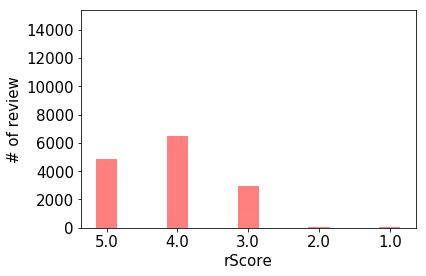

In [177]:
att_union_result = reviewer_who_satisfy_some_condition_union(att_data, 1, 1, 1, 1, 1, 1, 7, 50, 10, 4.5, 5, 10, -1)

In [178]:
union_result_df = pd.DataFrame(att_union_result)
writer = pd.ExcelWriter('attrangs_feature.xlsx')
union_result_df.to_excel(writer,'Sheet1')
writer.save()

# 스타일난다

In [179]:
common_front = '../../dataset/sn_0715/stylenanda_' 
common_back = '.json'

def get_file(file_num):   
    file_path = common_front + str(file_num) + common_back
    json_data = open(file_path).read()
    data = json.loads(json_data)
    df_data = pd.DataFrame(data)
    return df_data

def concat_file(file_num):
    start_file = pd.DataFrame(get_file(1))
    for i in range(2,file_num+1):
        df_tmp = pd.DataFrame(get_file(i))
        start_file = pd.concat([start_file, df_tmp])
    start_file = start_file.reset_index(drop=True)
    return start_file

In [180]:
sn_data = concat_file(61)
sn_data

,_id,bodySize,cId,desc,height,helpful,pColor,pID,pSize,pTitle,pURL,rImages,rNo,rScore,shoeSize,weight
0,stylenanda_544486,NaN,yj7***,심플하게 입을때 허리에 포인트주면 이쁠거같아용!난다메이드는 사랑입니당,158.0,"[0, 0]",블랙,226976,FRE,드로우진주 글램포인트벨트7월 31일부터 순차 배송가능!!,http://stylenanda.com/front/php/product.php?product_no=226976,NaN,544486,4.0,225.0,NaN
1,stylenanda_544485,NaN,yj7***,허리사이즈도 딱 맞고 길이도 적당하고 너무 이뻐용,158.0,"[0, 0]",블루진,230154,S,내추럴데미지 미니데님sk,http://stylenanda.com/front/php/product.php?product_no=230154,NaN,544485,5.0,225.0,NaN
2,stylenanda_544484,NaN,yj7***,사진으로 보는거랑 생각했던 거랑 재질이 많이 달라요.그래도 귀여운디자인에 한눈에 반해서 샀습니당,158.0,"[0, 0]",레드,229168,FRE,캔디오션 버튼다운 st원피스,http://stylenanda.com/front/php/product.php?product_no=229168,NaN,544484,4.0,225.0,NaN
3,stylenanda_544483,NaN,yj7***,박시하게 입어도 되고 허리끈 묶어서 입어도 되고 이쁩니다~,158.0,"[0, 0]",화이트,227429,FRE,레터링스피릿 끈드롭 박시하프티7월 31일부터 순차 배송가능!!,http://stylenanda.com/front/php/product.php?product_no=227429,NaN,544483,4.0,225.0,NaN
4,stylenanda_544482,NaN,yj7***,허리가 얇은편인데 제곱바지는 허리가 딱맞아서 좋아요!,158.0,"[0, 0]",블루진,228627,S,사이드엣지 브라이트데님 숏pt,http://stylenanda.com/front/php/product.php?product_no=228627,NaN,544482,5.0,225.0,NaN
5,stylenanda_544481,M,mi3377l***,사진과 동일하고 레이스가 풍성하고 예쁩니다소녀소녀하고 배송도 생각보다 빠르고 세일때 저렴하게 잘 구입했습니다 스타일난다는 역시 믿고 삽니다,172.0,"[0, 0]",블랙,226919,FRE,소피 레이스리본 빅헤어핀,http://stylenanda.com/front/php/product.php?product_no=226919,NaN,544481,5.0,250.0,56~59
6,stylenanda_544480,NaN,gbles***,몇년전에 샀었는데 너무 오래사용해서 또 같은거 샀네요~~ 예전보다 로고부분이 자수로 변해서 더 좋은것 같아요~~ 휴대용으로 가지고 다니기에는 이 사이즈가 좋은것 같네요~~,NaN,"[0, 0]",블랙,96988,FRE,3ce pouch_small,http://stylenanda.com/front/php/product.php?product_no=96988,NaN,544480,5.0,NaN,NaN
7,stylenanda_544479,NaN,gbles***,약간 색감이 비늘? 같은 색감이예요~~좀더 푸른끼가 있다고 해야 하나~~다른 글리터들에 비해 굵은 것들이 있어서 확실히 포인트를 줄 수가 있네요~~,NaN,"[0, 0]",DOUBLE NOTE,223353,FRE,3ce eye switch #double note,http://stylenanda.com/front/php/product.php?product_no=223353,NaN,544479,5.0,NaN,NaN
8,stylenanda_544478,M,gbles***,좀 얇을 줄 알았는데 중간정도의 두꼐군요.ㅎㅎ봄 가을 겨울까지 입을 수 있을 것 같아요~~디자인이 스포티해서 예쁘고 넉넉한 핏이라서 편하게 잘 맞네요~~ 빨리 쌀쌀해졌으면 좋겠어요;.ㅎㅎ,160.0,"[0, 0]",블랙,226072,FRE,캐주얼폭시 와이드트랙 트레이닝pt,http://stylenanda.com/front/php/product.php?product_no=226072,NaN,544478,5.0,245.0,50~55
9,stylenanda_544477,M,gbles***,보통 잘 없는 색감이라서 구매해 봤습니다~~블루톤의 원피스와 매치하려고 샀는데 이너로 잘 어울리는 것 같아요~~ 적당한 길이와 적당한 핏이라서 무난무난하게 여기저기 잘 입을 수 있을 것 같아요~~,160.0,"[0, 0]",블루그레이,227413,FRE,훈훈해 롤업반소매 미니멀t블랙 주문 폭주! 순차적으로 보내드릴게요~여유 있게 주문해주세요^^,http://stylenanda.com/front/php/product.php?product_no=227413,NaN,544477,5.0,245.0,50~55


# reviewer_who_satisfy_some_condition -sn union ver.

In [183]:
sn_union_public_total = []
sn_union_public_rscore_5 = []
sn_union_public_rscore_4 = []
sn_union_public_rscore_3 = []
sn_union_public_rscore_2 = []
sn_union_public_rscore_1 = []

In [184]:
def reviewer_who_satisfy_some_condition_union(dataframe, cond1_bool, cond2_bool, cond3_bool, cond4_bool, cond5_bool, cond6_bool,
                                        cond1, cond2, cond3, cond4, cond5, cond6, max_rscore):
    
     #condition1
    if(cond1_bool == 1):
        reviewer1 = burst_in_product(cond1, dataframe)
    else:
        reviewer1 = []
    
    #condition2
    if(cond2_bool == 1):
        reviewer2 = find_reviewer_who_has_many_reviews(cond2, dataframe)
    else:
        reviewer2 = []
        
    #condition3
    if(cond3_bool == 1):
        reviewer3 = reviewer_who_directly_write_sitename(cond3, dataframe)
    else:
        reviewer3 = []
    
    #condition4
    if(cond4_bool == 1):
        reviewer4 = reviewer_who_has_high_rscore(cond4, dataframe)
    else:
        reviewer4 = []
        
    #condition5
    if(cond5_bool == 1):
        reviewer5 = reviewer_who_has_many_reviews_in_a_product(cond5, dataframe)
    else:
        reviewer5 = []  

    #condition6
    if(cond6_bool == 1):
        reviewer6 = reviewer_who_has_many_reviews_in_a_day(cond6, dataframe)
    else:
        reviewer6 = []
        
    spam_reviewers = remove_duplicate_from_list(reviewer1 + reviewer2 + reviewer3 + reviewer4 + reviewer5 + reviewer6)
    
    
    #네이버 페이 구매자는 스패머에서 일단 제외
    if(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790' in spam_reviewers):
        spam_reviewers.remove(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790')
    
    except_spam_in_gogosing = dataframe[~dataframe.cId.isin(spam_reviewers)]
    print("total number of expected non-spam reviewers : " + str(len(except_spam_in_gogosing.cId.unique()))) 
    
    #제외될 리뷰중 3.0 이하의 리뷰는 제거하지 않음
    low_rscore_in_spam_reviewers = (dataframe[dataframe.cId.isin(spam_reviewers)]).loc[dataframe['rScore']<= max_rscore]
    except_spam_in_gogosing = pd.concat([except_spam_in_gogosing, low_rscore_in_spam_reviewers])
    
    print("total number of suspicious spam reviewers : " + str(len(spam_reviewers)))
      
    print("<rScore distribution>")
    print("cond1 =" + str(cond1) + ", cond2 =" + str(cond2) + ", cond3 =" + str(cond3) + ", cond4 =" + str(cond4) + ", cond5 =" + str(cond5) + ", cond6 =" + str(cond6)) 
    
    rscore = except_spam_in_gogosing['rScore'].value_counts()

    if(not(5.0 in rscore.index)):
        add_row = pd.Series([1], index=[5.0])
        rscore = rscore.add(add_row)
    if(not(4.0 in rscore.index)):
        add_row = pd.Series([1], index=[4.0])
        rscore = rscore.add(add_row)
    if(not(3.0 in rscore.index)):
        add_row = pd.Series([1], index=[3.0])
        rscore = rscore.add(add_row)
    if(not(2.0 in rscore.index)):
        add_row = pd.Series([1], index=[2.0])
        rscore = rscore.add(add_row)
    if(not(1.0 in rscore.index)):
        add_row = pd.Series([1], index=[1.0])
        rscore = rscore.add(add_row)  
        
    att_union_public_total.append(except_spam_in_gogosing.shape[0])
    att_union_public_rscore_5.append(rscore[5.0])
    att_union_public_rscore_4.append(rscore[4.0])
    att_union_public_rscore_3.append(rscore[3.0])
    att_union_public_rscore_2.append(rscore[2.0])
    att_union_public_rscore_1.append(rscore[1.0])

    non_spam_reviewers = except_spam_in_gogosing.cId.unique()
    non_spam_reviewers = non_spam_reviewers.tolist()
    
    if(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790' in non_spam_reviewers):
        non_spam_reviewers.remove(u'\ub124\uc774\ubc84 \ud398\uc774 \uad6c\ub9e4\uc790')
   
    print ("ratio btw 5.0 and 4.0 : " + str(float(rscore[5.0])/float(rscore[4.0])))
    print ("ratio btw 5.0 and 3.0 : " + str(float(rscore[5.0])/float(rscore[3.0])))
    print ("ratio btw 5.0 and 2.0 : " + str(float(rscore[5.0])/float(rscore[2.0])))
    print ("ratio btw 5.0 and 1.0 : " + str(float(rscore[5.0])/float(rscore[1.0])))
    

    print ("the number of 5.0 reviews : " + str(rscore[5.0]))
    print ("the number of 4.0 reviews : " + str(rscore[4.0]))
    print ("the number of 3.0 reviews : " + str(rscore[3.0]))
    print ("the number of 2.0 reviews : " + str(rscore[2.0]))
    print ("the number of 1.0 reviews : " + str(rscore[1.0]))
    
                    
    score = ('5.0', '4.0', '3.0', '2.0', '1.0')
    number_of_reviews = [rscore[5.0],
                     rscore[4.0],
                     rscore[3.0],
                     rscore[2.0],
                     rscore[1.0]]

    plt.bar(score, number_of_reviews, color=['red'],
        width=0.3, alpha=0.5)
    plt.xticks(score, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('# of review', fontsize=15)
    plt.rcParams["figure.figsize"] = (6,4)
    plt.xlabel('rScore', fontsize=15)
    ax = plt.gca()
    ax.set_ylim([0.0, except_spam_in_gogosing.shape[0]+1000])
    plt.show()
    print("\n\n")
    return spam_reviewers

total number of expected non-spam reviewers : 6473
total number of suspicious spam reviewers : 36444
<rScore distribution>
cond1 =10, cond2 =100, cond3 =15, cond4 =4.9, cond5 =10, cond6 =10
ratio btw 5.0 and 4.0 : 4.26740352918
ratio btw 5.0 and 3.0 : 10.8918584509
ratio btw 5.0 and 2.0 : 37.4268707483
ratio btw 5.0 and 1.0 : 48.0502183406
the number of 5.0 reviews : 44014
the number of 4.0 reviews : 10314
the number of 3.0 reviews : 4041
the number of 2.0 reviews : 1176
the number of 1.0 reviews : 916


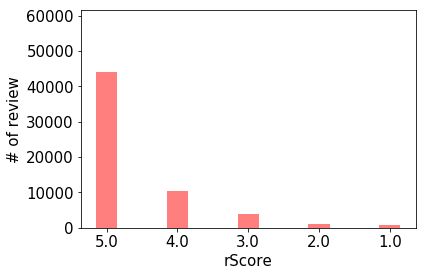

In [191]:
sn_union_result = reviewer_who_satisfy_some_condition_union(sn_data, 0, 1, 1, 1, 1, 0, 10, 100, 15, 4.9, 10, 10, -1)

In [193]:
union_result_df = pd.DataFrame(sn_union_result)
writer = pd.ExcelWriter('sn_feature.xlsx')
union_result_df.to_excel(writer,'Sheet1')
writer.save()